# Simple Linear Regression Analysis: Auto Sales eBay Germany (Random 50k Cleaned)

Goal: Use clear, simple linear regression (OLS) to understand which variables significantly impact car prices.

Key decisions:
- Keep `registration_year` (no age transform).
- Significance threshold: p < 0.05.
- Model selection: start with a full multiple regression and perform backward elimination by statistical significance (using ANOVA Type II for factor-level blocks).
- Ensure the modeling dataset has no missing values.
- Include simplified `model` and `postal_code` (as `model_simplified` and two-digit `postal_area`), and engineered `time_spent_on_market` where available.


## Statistics refresher: what OLS does and how to read it
- Linear regression (OLS) estimates the average relationship between a target (here: price_EUR) and predictors by fitting a straight-line function that minimizes the sum of squared residuals (differences between actual and fitted values).
- Coefficient (beta): expected change in the target for a one-unit increase in the predictor, holding all other variables constant (in multiple regression). Units matter.
- p-value (for a coefficient): probability of observing an effect at least as extreme as the one estimated if the true effect were 0. Small p-values (e.g., < 0.05) provide evidence against the null (no effect).
- 95% Confidence Interval (CI): a range that, under repeated sampling, would contain the true coefficient ~95% of the time. Narrower is more precise.
- R²: fraction of variance in the target explained by the model. Higher is better, but it always increases when you add variables.
- Adjusted R²: like R² but penalizes you for adding predictors that don’t help; use this to compare models with different numbers of predictors.
- For categorical variables, OLS uses dummy encoding: one level is the “baseline,” other levels’ coefficients are interpreted relative to that baseline.
- Assumptions (we’ll check informally): linearity, independent errors, constant variance (homoscedasticity), and roughly normal residuals. Violations don’t necessarily invalidate insights but affect inference quality.

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (8, 5)
os.makedirs("Visualizations", exist_ok=True)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 120)

ALPHA = 0.05  # significance threshold

## 1) Load Data and Quick Overview

In [5]:
DATA_PATH = "../Data/autos_random_50k_cleaned.csv"
df_raw = pd.read_csv(DATA_PATH)
# Drop any auto-added unnamed index columns
df_raw = df_raw.loc[:, ~df_raw.columns.str.startswith('Unnamed:')]
print('Shape:', df_raw.shape)
df_raw.head()

Shape: (37866, 17)


,date_crawled,car_name,price_EUR,ab_test,vehicle_type,registration_year,transmission,power_ps,model,odometer_km,registration_month,fuel_type,brand,unrepaired_damage,ad_created,postal_code,last_seen
0,2016-04-02 14:51,Astra_G_Cabrio_Turbo_235_PS,5200,test,cabrio,2002,manuell,235,astra,125000,5,Unknown,opel,nein,2016-04-02 0:00,47652,2016-04-06 13:17
1,2016-03-19 18:36,Fiat_Grande_Punto_1.2_8V__MIT_2_JAHREN_GARANTIE,3400,test,kleinwagen,2006,manuell,65,andere,125000,5,benzin,fiat,nein,2016-03-19 0:00,66538,2016-04-07 7:15
2,2016-03-09 20:59,Volvo_XC60_D5_AWD_Aut.,5200,test,suv,2009,automatik,220,xc_reihe,150000,3,diesel,volvo,ja,2016-03-09 0:00,72762,2016-03-16 5:46
3,2016-03-26 15:55,Kombi_Technisch_super_in_Schuss,750,test,kombi,2000,manuell,112,mondeo,150000,12,benzin,ford,Unknown,2016-03-26 0:00,39446,2016-03-26 15:55
4,2016-03-29 14:47,Audi_A4_1.9_TDI_quattro_Delphingrau,3522,test,limousine,2004,manuell,131,a4,150000,7,diesel,audi,nein,2016-03-29 0:00,51373,2016-03-29 14:47


In [6]:
print('Columns:', df_raw.columns.tolist())
display(df_raw.describe(include='all').T.iloc[:20])  # first 20 rows for brevity
df_raw.dtypes.to_frame('dtype').T

Columns: ['date_crawled', 'car_name', 'price_EUR', 'ab_test', 'vehicle_type', 'registration_year', 'transmission', 'power_ps', 'model', 'odometer_km', 'registration_month', 'fuel_type', 'brand', 'unrepaired_damage', 'ad_created', 'postal_code', 'last_seen']


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date_crawled,37866,11420,2016-03-30 19:50,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
car_name,37866,28377,BMW_318i,92,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price_EUR,37866.0,NaN,NaN,NaN,6838.213595,11615.915258,500.0,1700.0,3950.0,8500.0,820000.0
ab_test,37866,2,test,19714,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vehicle_type,37866,9,limousine,11046,NaN,NaN,NaN,NaN,NaN,NaN,NaN
registration_year,37866.0,NaN,NaN,NaN,2003.529314,6.725368,1929.0,2000.0,2004.0,2008.0,2016.0
transmission,37866,3,manuell,28481,NaN,NaN,NaN,NaN,NaN,NaN,NaN
power_ps,37866.0,NaN,NaN,NaN,129.625363,64.633507,1.0,86.0,116.0,156.0,1403.0
model,37866,244,golf,3117,NaN,NaN,NaN,NaN,NaN,NaN,NaN
odometer_km,37866.0,NaN,NaN,NaN,124270.717794,39764.869422,5000.0,100000.0,150000.0,150000.0,150000.0


,date_crawled,car_name,price_EUR,ab_test,vehicle_type,registration_year,transmission,power_ps,model,odometer_km,registration_month,fuel_type,brand,unrepaired_damage,ad_created,postal_code,last_seen
dtype,object,object,int64,object,object,int64,object,int64,object,int64,int64,object,object,object,object,int64,object


Why drop “Unnamed:” columns?
- CSVs sometimes include an index column with a header like `Unnamed: 0`. It does not contain analytical information, so we remove it to avoid accidental use as a predictor.

## 2) Simple Visuals: Price Distribution
We keep both the full-range histogram and a zoomed version (≤ €50k) for readability.
- Used-car prices are typically right-skewed (many affordable cars, a tail of expensive listings). The zoomed view helps focus on the bulk without hiding the tail.

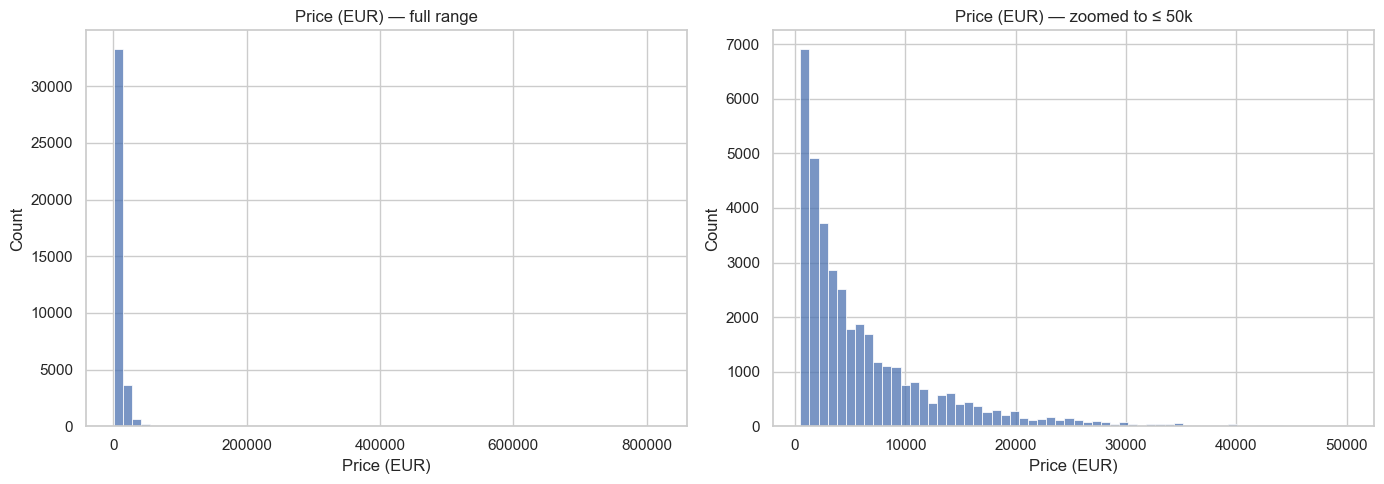

99.5% of listings have price ≤ €50,000


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df_raw['price_EUR'], bins=60, ax=axes[0])
axes[0].set_title('Price (EUR) — full range')
axes[0].set_xlabel('Price (EUR)')

df_zoom = df_raw[df_raw['price_EUR'].between(0, 50000)]
share_zoom = len(df_zoom) / len(df_raw) if len(df_raw) else np.nan
sns.histplot(df_zoom['price_EUR'], bins=60, ax=axes[1])
axes[1].set_title('Price (EUR) — zoomed to ≤ 50k')
axes[1].set_xlabel('Price (EUR)')
plt.tight_layout()
plt.show()
print(f"{share_zoom:.1%} of listings have price ≤ €50,000")

## 3) Prepare Clean Dataset (No Missing Values in Selected Variables)
We keep a simple set of predictors and ensure complete cases:
- Target: `price_EUR`
- Numeric predictors: `power_ps`, `odometer_km`, `registration_year`, `registration_month` (if present), and engineered `time_spent_on_market` (days) where available.
- Categorical predictors: `brand_simplified`, `model_simplified`, `vehicle_type`, `transmission`, `fuel_type`, `unrepaired_damage`, and regional `postal_area` (first 2 digits).

We also apply simple plausibility filters to remove obvious errors.

In [8]:
df = df_raw.copy()

# Ensure numeric where appropriate
for c in ['price_EUR','power_ps','odometer_km','registration_year','registration_month','postal_code']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Parse dates for engineered time_spent_on_market (days)
if 'date_created' in df.columns:
    df['date_created'] = pd.to_datetime(df['date_created'], errors='coerce')
if 'last_seen_online' in df.columns:
    df['last_seen_online'] = pd.to_datetime(df['last_seen_online'], errors='coerce')
if 'date_created' in df.columns and 'last_seen_online' in df.columns:
    df['time_spent_on_market'] = (df['last_seen_online'] - df['date_created']).dt.days
    df['time_spent_on_market'] = df['time_spent_on_market'].clip(lower=0)

# Simple plausibility filters
mask = pd.Series(True, index=df.index)
if 'price_EUR' in df.columns:
    mask &= (df['price_EUR'] >= 100) & (df['price_EUR'] <= 100000)
if 'power_ps' in df.columns:
    mask &= (df['power_ps'] >= 20) & (df['power_ps'] <= 500)
if 'odometer_km' in df.columns:
    mask &= (df['odometer_km'] >= 0) & (df['odometer_km'] <= 300000)
if 'registration_year' in df.columns:
    mask &= (df['registration_year'] >= 1950) & (df['registration_year'] <= 2016)
df = df[mask].copy()

# Keep a manageable number of brand levels to keep the model simple
if 'brand' in df.columns:
    top_brands = df['brand'].value_counts().nlargest(15).index
    df['brand_simplified'] = df['brand'].where(df['brand'].isin(top_brands), 'Other')
else:
    df['brand_simplified'] = np.nan

# Simplify model (top 30 most frequent; others -> 'Other')
if 'model' in df.columns:
    top_models = df['model'].value_counts().nlargest(30).index
    df['model_simplified'] = df['model'].where(df['model'].isin(top_models), 'Other')
else:
    df['model_simplified'] = np.nan

# Postal area from first two digits of postal_code
if 'postal_code' in df.columns:
    df['postal_area'] = pd.to_numeric(df['postal_code'], errors='coerce').astype('Int64').astype(str).str[:2].replace({'<NA>': np.nan})
else:
    df['postal_area'] = np.nan

# Select columns for modeling
numeric_vars = [c for c in ['power_ps','odometer_km','registration_year','registration_month','time_spent_on_market'] if c in df.columns]
categorical_vars = [c for c in ['brand_simplified','model_simplified','vehicle_type','transmission','fuel_type','unrepaired_damage','postal_area'] if c in df.columns]
target = 'price_EUR'

model_cols = [target] + numeric_vars + categorical_vars
dfm = df[model_cols].copy()

# Drop rows with any missing values in the modeling columns
before = len(dfm)
dfm = dfm.dropna(axis=0, how='any')
after = len(dfm)
print(f"Rows before dropna: {before}")
print(f"Rows after dropna:  {after}")
print("Remaining NA in modeling set:")
print(dfm.isna().sum())
assert dfm.isna().sum().sum() == 0, "There are unexpected missing values in the modeling dataset."

Rows before dropna: 37744
Rows after dropna:  37744
Remaining NA in modeling set:
price_EUR             0
power_ps              0
odometer_km           0
registration_year     0
registration_month    0
brand_simplified      0
model_simplified      0
vehicle_type          0
transmission          0
fuel_type             0
unrepaired_damage     0
postal_area           0
dtype: int64


Why these cleaning choices?
- We convert columns to numeric (errors coerced to NaN) so the model can compute on numbers only.
- Simple plausibility filters remove obvious data-entry errors (e.g., 2 million km odometer, 0 price, etc.). This makes the model more robust and easier to interpret.
- `model_simplified` keeps the most common models and groups the rest as “Other” to avoid thousands of dummies (unstable estimates, slow fitting) while preserving signal.
- `postal_area` (first two digits) captures regional effects without exploding the number of categories.
- We use complete cases (drop rows with any missing among selected columns) to ensure statsmodels OLS and ANOVA calculations are well-defined and consistent across fits.

## 4) Simple Relationship Plots
These are for intuition only; the regression model will quantify effects and significance.
- Use scatterplots for numeric predictors except `registration_month`.
- For `registration_month`, use a boxplot of price by month (more interpretable than scatter stripes).

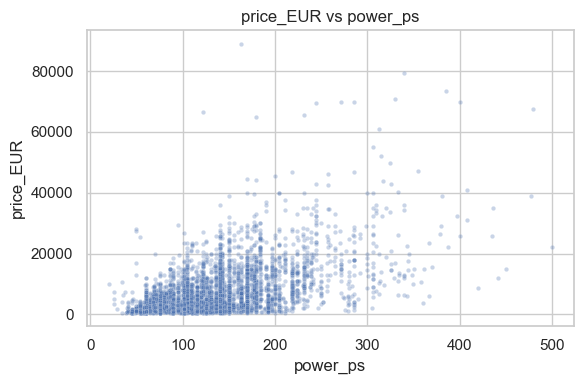

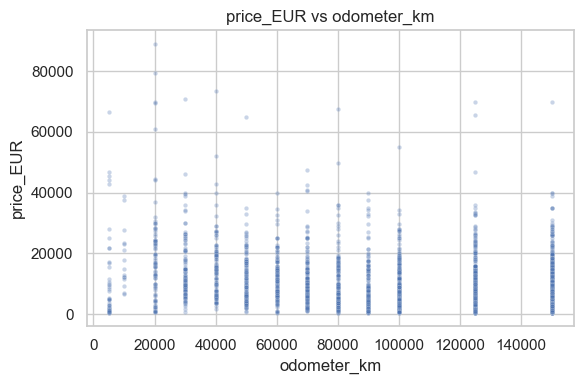

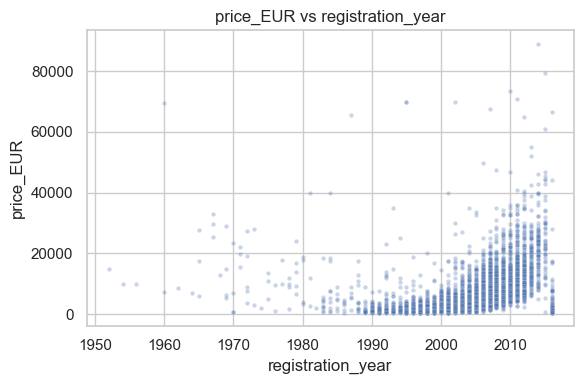

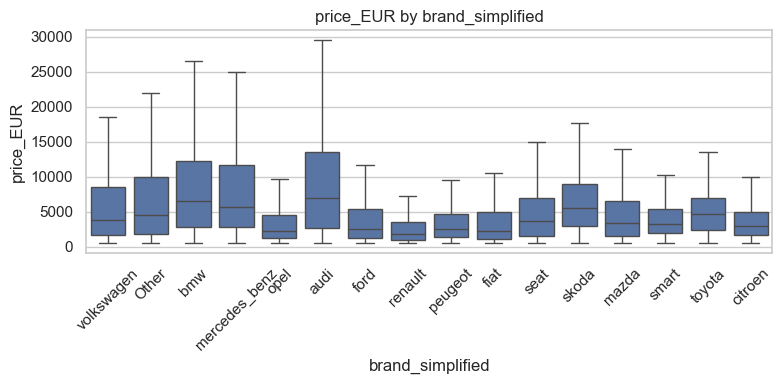

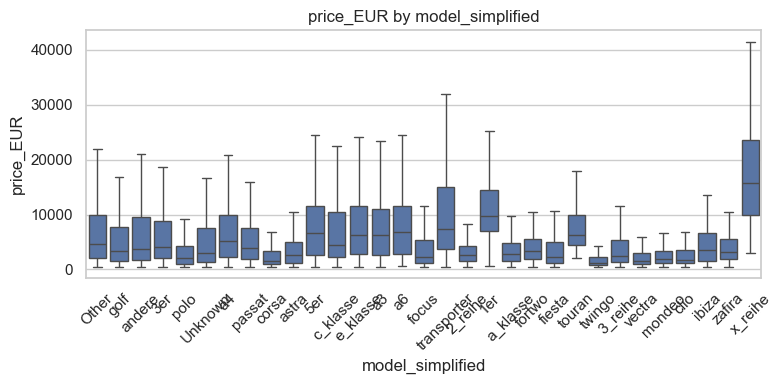

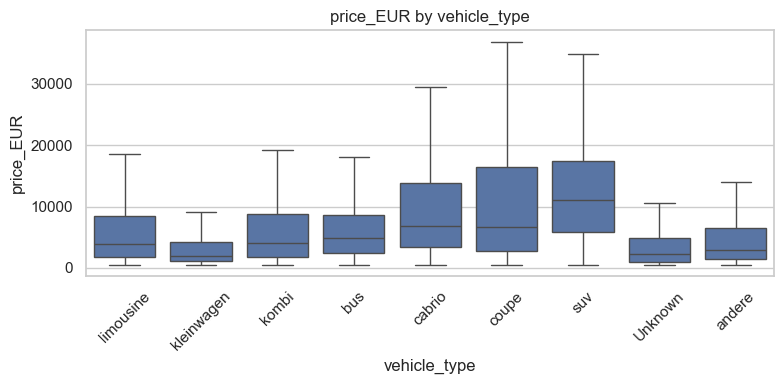

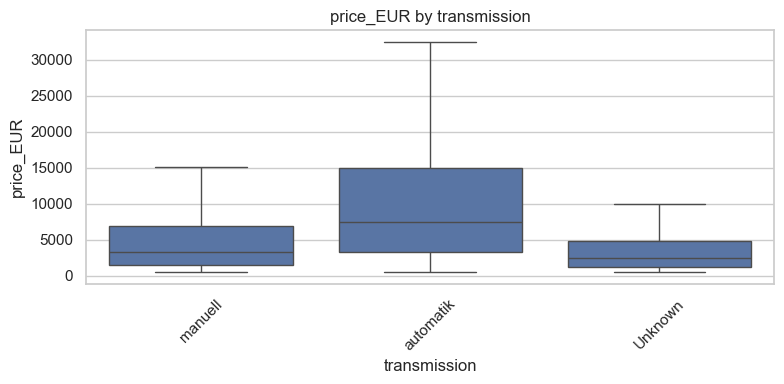

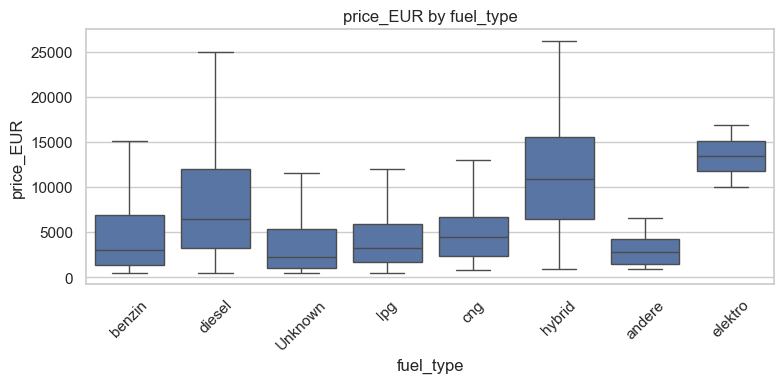

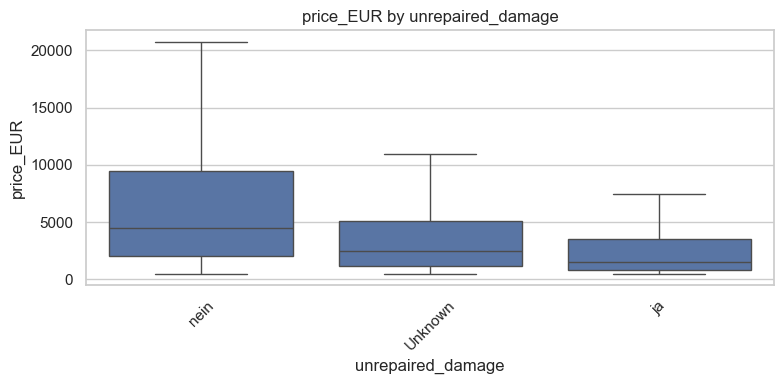

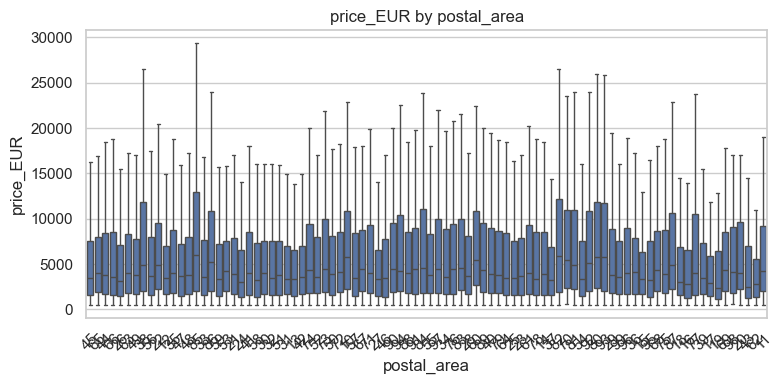

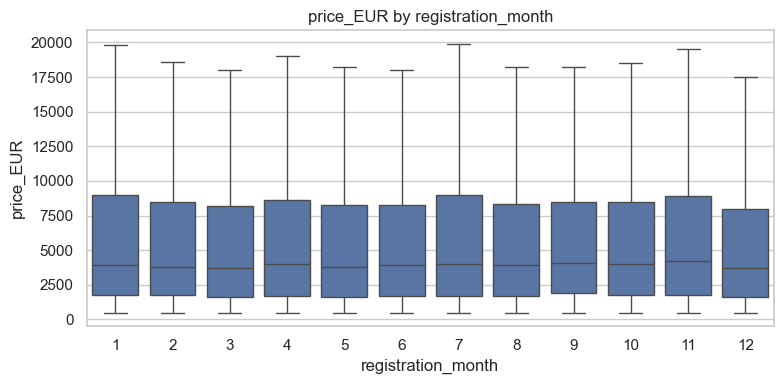

In [9]:
# Scatter: price vs numeric predictors (except registration_month)
numeric_vars_for_scatter = [v for v in numeric_vars if v in dfm.columns and v != 'registration_month']
for var in numeric_vars_for_scatter:
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=dfm.sample(min(5000, len(dfm)), random_state=42), x=var, y=target, alpha=0.3, s=10)
    plt.title(f'{target} vs {var}')
    plt.tight_layout()
    plt.show()

# Boxplots: price vs categorical predictors
for var in [v for v in categorical_vars if v in dfm.columns]:
    plt.figure(figsize=(8,4))
    order = dfm[var].value_counts().index
    sns.boxplot(data=dfm, x=var, y=target, order=order, showfliers=False)
    plt.title(f'{target} by {var}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Boxplot for registration_month (treated as categorical for visualization only)
if 'registration_month' in dfm.columns:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=dfm['registration_month'].astype(int), y=dfm[target], showfliers=False)
    plt.title(f'{target} by registration_month')
    plt.xlabel('registration_month')
    plt.tight_layout()
    plt.show()

How to read these plots
- Scatter: a positive slope cloud suggests a positive relationship (e.g., more PS → higher price). A negative slope cloud suggests an inverse relationship (e.g., more mileage → lower price). Expect scatter and overlap.
- Boxplots: look at the median line and the spread. Systematic shifts across categories (e.g., some brands consistently higher medians) suggest significant categorical effects.

## 5) Univariate OLS Regressions
We fit simple OLS models of price on each predictor separately to check individual significance. For categorical variables we treat them as factors using `C(var)` and use an ANOVA to assess overall significance.

How to interpret univariate results
- For a numeric predictor X: the slope tells you the average change in price per unit increase in X (without controlling for other variables). R² tells you how much variability in price is explained by X alone.
- For a categorical predictor C: the ANOVA p-value tests whether mean prices differ across levels of C. Significant p-values indicate that at least one level differs from the baseline.
- Caution: univariate relationships can be misleading due to confounding. Multiple regression adjusts for other predictors.

In [10]:
results_uni = []

# Numeric predictors: price_EUR ~ x
for var in numeric_vars:
    formula = f"{target} ~ {var}"
    model = smf.ols(formula, data=dfm).fit()
    pval = model.pvalues.get(var, np.nan)
    r2 = model.rsquared
    results_uni.append({'predictor': var, 'type': 'numeric', 'p_value': pval, 'R2': r2, 'formula': formula})

# Categorical predictors: price_EUR ~ C(var) with ANOVA Type II
for var in categorical_vars:
    formula = f"{target} ~ C({var})"
    model = smf.ols(formula, data=dfm).fit()
    anov = anova_lm(model, typ=2)
    term = f"C({var})"
    pval = anov.loc[term, 'PR(>F)'] if term in anov.index else np.nan
    r2 = model.rsquared
    results_uni.append({'predictor': var, 'type': 'categorical', 'p_value': pval, 'R2': r2, 'formula': formula})

uni_df = pd.DataFrame(results_uni).sort_values(['type','p_value'])
display(uni_df)

,predictor,type,p_value,R2,formula
4,brand_simplified,categorical,0.000000e+00,0.077385,price_EUR ~ C(brand_simplified)
5,model_simplified,categorical,0.000000e+00,0.080238,price_EUR ~ C(model_simplified)
6,vehicle_type,categorical,0.000000e+00,0.117637,price_EUR ~ C(vehicle_type)
7,transmission,categorical,0.000000e+00,0.094930,price_EUR ~ C(transmission)
8,fuel_type,categorical,0.000000e+00,0.047841,price_EUR ~ C(fuel_type)
9,unrepaired_damage,categorical,5.896292e-274,0.032790,price_EUR ~ C(unrepaired_damage)
10,postal_area,categorical,1.320160e-88,0.017435,price_EUR ~ C(postal_area)
0,power_ps,numeric,0.000000e+00,0.329969,price_EUR ~ power_ps
1,odometer_km,numeric,0.000000e+00,0.209054,price_EUR ~ odometer_km
2,registration_year,numeric,0.000000e+00,0.157855,price_EUR ~ registration_year


Reading `uni_df`
- `p_value`: smaller means stronger evidence the predictor is associated with price in isolation.
- `R2`: proportion of price variance explained by that single predictor; helpful for gauging effect size in isolation.
- Use these as hints; the multiple regression below is the main result because it accounts for all variables simultaneously.

## 6) Multiple Regression (Full Model)
We include all selected predictors at once:

price_EUR ~ power_ps + odometer_km + registration_year [+ registration_month + time_spent_on_market] + C(brand_simplified) + C(model_simplified) + C(vehicle_type) + C(transmission) + C(fuel_type) + C(unrepaired_damage) + C(postal_area)

Note: Terms in brackets are included only if present in the data.

How to interpret coefficients here
- Numeric: “holding others constant,” a one-unit increase in X changes price by ‘coef’ euros on average. For example, if `power_ps` coef = 45, +1 PS → +€45.
- Categorical: coefficients represent the difference vs the baseline level (the category alphabetically first, unless statsmodels shows the baseline in the summary). A positive coefficient means that level is pricier than baseline on average; negative means cheaper.
- Focus on sign, magnitude, and p-value. Also check the CI for plausibility and precision.

In [11]:
def build_formula(num_vars, cat_vars):
    terms = []
    terms += num_vars
    terms += [f"C({c})" for c in cat_vars]
    rhs = " + ".join(terms)
    return f"{target} ~ {rhs}" if rhs else f"{target} ~ 1"

full_formula = build_formula(numeric_vars, categorical_vars)
print('Full formula:')
print(full_formula)
full_model = smf.ols(full_formula, data=dfm).fit()
display(full_model.summary())
print({'R2': full_model.rsquared, 'Adj_R2': full_model.rsquared_adj})

Full formula:
price_EUR ~ power_ps + odometer_km + registration_year + registration_month + C(brand_simplified) + C(model_simplified) + C(vehicle_type) + C(transmission) + C(fuel_type) + C(unrepaired_damage) + C(postal_area)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_EUR   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     408.9
Date:                Wed, 22 Oct 2025   Prob (F-statistic):               0.00
Time:                        09:59:49   Log-Likelihood:            -3.7291e+05
No. Observations:               37744   AIC:                         7.461e+05
Df Residuals:                   37586   BIC:                         7.475e+05
Df Model:                         157                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                            -3.253e+05   9536.829    -34.111      0.000   -3.44e+05   -3.07e+05
C(brand_simplified)[T.audi]           2070.4994    170.476     12.145      0.000    1736.361    2404.638
C(brand_simplified)[T.bmw]            -168.8086    243.536     -0.693      0.488    -646.145     308.528
C(brand_simplified)[T.citroen]       -1279.9542    220.697     -5.800      0.000   -1712.525    -847.383
C(brand_simplified)[T.fiat]           -722.3718    184.065     -3.925      0.000   -1083.144    -361.600
C(brand_simplified)[T.ford]          -1021.2751    179.209     -5.699      0.000   -1372.529    -670.021
C(brand_simplified)[T.mazda]         -1373.3824    215.182     -6.382      0.000   -1795.145    -951.619
C(brand_simplified)[T.mercedes_benz]   469.6924    145.158      3.236      0.001     185.179     754.206
C(brand_simplified)[T.opel]          -1324.2646    185.204     -7.150      0.000   -1687.270    -961.259
C(brand_simplified)[T.peugeot]       -1425.9328    240.472     -5.930      0.000   -1897.264    -954.601
C(brand_simplified)[T.renault]       -1456.3131    183.895     -7.919      0.000   -1816.752   -1095.874
C(brand_simplified)[T.seat]           -169.6614    251.225     -0.675      0.499    -662.069     322.746
C(brand_simplified)[T.skoda]           346.5579    199.277      1.739      0.082     -44.030     737.146
C(brand_simplified)[T.smart]         -1362.0941    539.417     -2.525      0.012   -2419.367    -304.821
C(brand_simplified)[T.toyota]         -854.9365    217.570     -3.929      0.000   -1281.380    -428.493
C(brand_simplified)[T.volkswagen]      989.9062    137.668      7.191      0.000     720.073    1259.740
C(model_simplified)[T.2_reihe]       -1326.6358    441.832     -3.003      0.003   -2192.638    -460.633
C(model_simplified)[T.3_reihe]       -1253.6143    437.880     -2.863      0.004   -2111.871    -395.358
C(model_simplified)[T.3er]           -1582.2328    237.267     -6.669      0.000   -2047.282   -1117.183
C(model_simplified)[T.5er]           -2171.5369    265.232     -8.187      0.000   -2691.400   -1651.674
C(model_simplified)[T.Other]         -1158.0953    316.017     -3.665      0.000   -1777.497    -538.693
C(model_simplified)[T.Unknown]        -832.4333    334.441     -2.489      0.013   -1487.947    -176.920
C(model_simplified)[T.a3]            -2315.2279    388.084     -5.966      0.000   -3075.882   -1554.574
C(model_simplified)[T.a4]            -3279.5224    375.671     -8.730      0.000   -4015.848   -2543.197
C(model_simplified)[T.a6]            -4224.6666    394.802    -10.701      0.000   -4998.489   -3450.844
C(model_simplified)[T.a_klasse]      -1604.1596    395.280     -4.058      0.000   -2378.919    -829.400
C(model_simplified)[T.andere]         

{'R2': np.float64(0.6307341590407798), 'Adj_R2': np.float64(0.6291917034181916)}


How to read the model summary
- “coef”: estimated effect; “std err”: standard error; “t” and “P>|t|”: test statistic and p-value for H0: coef = 0.
- “[0.025, 0.975]”: 95% CI; if it excludes 0, the effect is significant at 5% level.
- “R-squared” vs “Adj. R-squared”: prefer Adjusted for comparing models with different numbers of predictors.
- “F-statistic” and its p-value test whether at least one predictor has a non-zero effect.
- For categorical variables, locate the baseline in the summary (often omitted as the intercept encodes it). Other levels’ coefs are relative to baseline.

## 7) Backward Elimination (p-value based)
We iteratively remove the least significant term (highest p-value > 0.05), using ANOVA Type II so categorical variables are treated as blocks. Stop when all remaining terms are significant or only the intercept remains.

Why Type II ANOVA and backward elimination?
- Type II tests each term adjusting for the other terms, which is appropriate when you care about each predictor’s contribution controlling for others.
- Backward elimination starts from the full model to reduce omitted-variable bias; it prunes non-contributing terms to get a simpler model.
- Caveats: stepwise procedures are heuristic and can be unstable across samples. Use them as practical simplification tools, not absolute arbiters of truth.

In [12]:
def backward_elimination(data, target, numeric_vars, categorical_vars, alpha=0.05, verbose=True):
    num_vars = list(numeric_vars)
    cat_vars = list(categorical_vars)
    steps = []
    while True:
        formula = build_formula(num_vars, cat_vars)
        model = smf.ols(formula, data=data).fit()
        anov = anova_lm(model, typ=2)
        # Exclude residual row
        anov_terms = anov.drop(index=[idx for idx in anov.index if idx.lower().startswith('resid')], errors='ignore')
        # If there are no terms, stop
        if anov_terms.empty:
            if verbose:
                print('No terms left beyond intercept. Stopping.')
            break
        worst_term = anov_terms['PR(>F)'].idxmax()
        worst_p = anov_terms['PR(>F)'].max()
        steps.append({'formula': formula, 'worst_term': worst_term, 'worst_p': worst_p, 'Adj_R2': model.rsquared_adj})
        if verbose:
            print(f"Current: Adj_R2={model.rsquared_adj:.4f}, Removing candidate: {worst_term} (p={worst_p:.4g})")
        if worst_p <= alpha:
            if verbose:
                print('All remaining terms significant. Stop.')
            break
        # Map worst_term back to variable name
        if worst_term.startswith('C(') and worst_term.endswith(')'):
            var = worst_term[2:].strip('()')
            if var in cat_vars:
                cat_vars.remove(var)
            else:
                # Safety: if not found, break
                if verbose:
                    print(f'Could not map term {worst_term} to categorical variable. Stopping.')
                break
        else:
            var = worst_term
            if var in num_vars:
                num_vars.remove(var)
            else:
                if verbose:
                    print(f'Could not map term {worst_term} to numeric variable. Stopping.')
                break
        # Continue loop
    # Fit final model
    final_formula = build_formula(num_vars, cat_vars)
    final_model = smf.ols(final_formula, data=data).fit()
    return final_model, final_formula, pd.DataFrame(steps)

final_model, final_formula, elim_steps = backward_elimination(dfm, target, numeric_vars, categorical_vars, alpha=ALPHA, verbose=True)
print('\nFinal formula after backward elimination:')
print(final_formula)
display(final_model.summary())
print({'Final_R2': final_model.rsquared, 'Final_Adj_R2': final_model.rsquared_adj})
elim_steps

Current: Adj_R2=0.6292, Removing candidate: registration_month (p=0.04134)
All remaining terms significant. Stop.

Final formula after backward elimination:
price_EUR ~ power_ps + odometer_km + registration_year + registration_month + C(brand_simplified) + C(model_simplified) + C(vehicle_type) + C(transmission) + C(fuel_type) + C(unrepaired_damage) + C(postal_area)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_EUR   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     408.9
Date:                Wed, 22 Oct 2025   Prob (F-statistic):               0.00
Time:                        09:59:53   Log-Likelihood:            -3.7291e+05
No. Observations:               37744   AIC:                         7.461e+05
Df Residuals:                   37586   BIC:                         7.475e+05
Df Model:                         157                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                            -3.253e+05   9536.829    -34.111      0.000   -3.44e+05   -3.07e+05
C(brand_simplified)[T.audi]           2070.4994    170.476     12.145      0.000    1736.361    2404.638
C(brand_simplified)[T.bmw]            -168.8086    243.536     -0.693      0.488    -646.145     308.528
C(brand_simplified)[T.citroen]       -1279.9542    220.697     -5.800      0.000   -1712.525    -847.383
C(brand_simplified)[T.fiat]           -722.3718    184.065     -3.925      0.000   -1083.144    -361.600
C(brand_simplified)[T.ford]          -1021.2751    179.209     -5.699      0.000   -1372.529    -670.021
C(brand_simplified)[T.mazda]         -1373.3824    215.182     -6.382      0.000   -1795.145    -951.619
C(brand_simplified)[T.mercedes_benz]   469.6924    145.158      3.236      0.001     185.179     754.206
C(brand_simplified)[T.opel]          -1324.2646    185.204     -7.150      0.000   -1687.270    -961.259
C(brand_simplified)[T.peugeot]       -1425.9328    240.472     -5.930      0.000   -1897.264    -954.601
C(brand_simplified)[T.renault]       -1456.3131    183.895     -7.919      0.000   -1816.752   -1095.874
C(brand_simplified)[T.seat]           -169.6614    251.225     -0.675      0.499    -662.069     322.746
C(brand_simplified)[T.skoda]           346.5579    199.277      1.739      0.082     -44.030     737.146
C(brand_simplified)[T.smart]         -1362.0941    539.417     -2.525      0.012   -2419.367    -304.821
C(brand_simplified)[T.toyota]         -854.9365    217.570     -3.929      0.000   -1281.380    -428.493
C(brand_simplified)[T.volkswagen]      989.9062    137.668      7.191      0.000     720.073    1259.740
C(model_simplified)[T.2_reihe]       -1326.6358    441.832     -3.003      0.003   -2192.638    -460.633
C(model_simplified)[T.3_reihe]       -1253.6143    437.880     -2.863      0.004   -2111.871    -395.358
C(model_simplified)[T.3er]           -1582.2328    237.267     -6.669      0.000   -2047.282   -1117.183
C(model_simplified)[T.5er]           -2171.5369    265.232     -8.187      0.000   -2691.400   -1651.674
C(model_simplified)[T.Other]         -1158.0953    316.017     -3.665      0.000   -1777.497    -538.693
C(model_simplified)[T.Unknown]        -832.4333    334.441     -2.489      0.013   -1487.947    -176.920
C(model_simplified)[T.a3]            -2315.2279    388.084     -5.966      0.000   -3075.882   -1554.574
C(model_simplified)[T.a4]            -3279.5224    375.671     -8.730      0.000   -4015.848   -2543.197
C(model_simplified)[T.a6]            -4224.6666    394.802    -10.701      0.000   -4998.489   -3450.844
C(model_simplified)[T.a_klasse]      -1604.1596    395.280     -4.058      0.000   -2378.919    -829.400
C(model_simplified)[T.andere]         

{'Final_R2': np.float64(0.6307341590407798), 'Final_Adj_R2': np.float64(0.6291917034181916)}


,formula,worst_term,worst_p,Adj_R2
0,price_EUR ~ power_ps + odometer_km + registration_year + registration_month + C(brand_simplified) + C(model_simplifi...,registration_month,0.041338,0.629192


Interpreting the elimination steps
- `worst_term`: the predictor (numeric) or factor (categorical as a block) slated for removal at that step.
- `worst_p`: its p-value after adjusting for the other terms in the current model.
- Track Adjusted R² across steps; if it drops substantially, consider whether to stop earlier (pragmatic judgment).

Optional: Multicollinearity quick check
- High correlation among predictors (e.g., two similar features) can inflate standard errors and make p-values less reliable.
- A simple check is Variance Inflation Factor (VIF) for numeric variables (categoricals expand to many dummies, so we keep this quick). Values > 5–10 warrant a closer look. Uncomment and run if desired.

In [13]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# import patsy
#
# # Build numeric-only design matrix for VIF (after dropping NA)
# num_df = dfm[[c for c in dfm.columns if c in ['price_EUR'] + numeric_vars]].copy()
# num_df = num_df.dropna()
# X = num_df[numeric_vars].assign(const=1.0)
# vif = pd.Series(
#     [variance_inflation_factor(X.values, i) for i in range(X.shape[1]-1)],
#     index=numeric_vars,
#     name='VIF'
# )
# display(vif)

## 8) Basic Diagnostics for the Final Model
We check residuals vs fitted, residual histogram, and Q–Q plot. These help assess linearity, homoscedasticity, and normality assumptions in a simple way.
- Residuals vs fitted: look for a random cloud around 0; systematic curves or funnel shapes indicate nonlinearity or heteroscedasticity.
- Histogram/Q–Q: strong deviations from normality can affect inference (p-values/CI). Mild deviations are common and often acceptable with large samples.

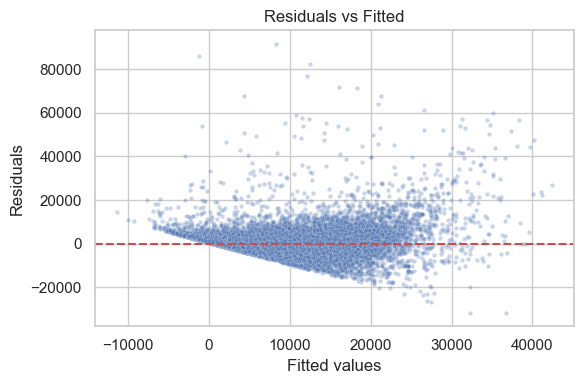

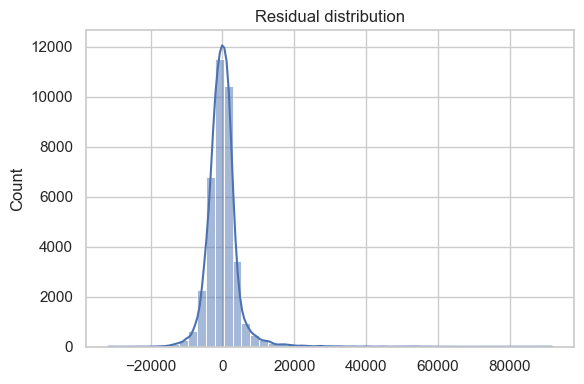

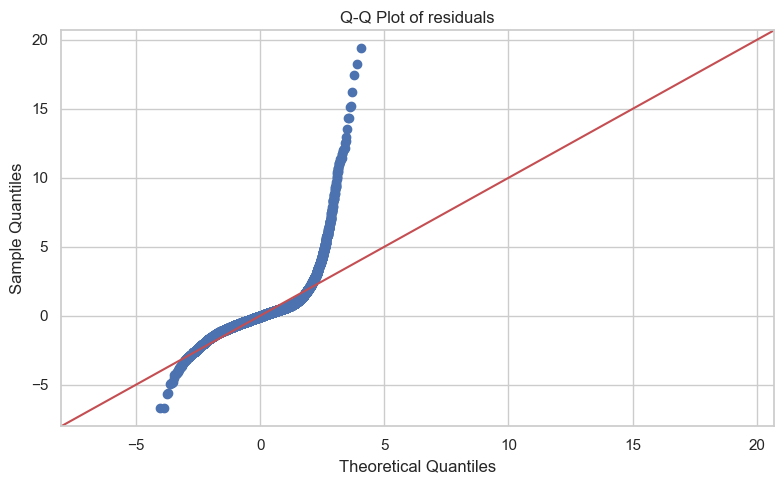

In [14]:
yhat = final_model.fittedvalues
resid = final_model.resid

# Residuals vs Fitted
plt.figure(figsize=(6,4))
sns.scatterplot(x=yhat, y=resid, alpha=0.3, s=10)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.tight_layout()
plt.show()

# Histogram of residuals
plt.figure(figsize=(6,4))
sns.histplot(resid, bins=50, kde=True)
plt.title('Residual distribution')
plt.tight_layout()
plt.show()

# Q–Q plot
fig = sm.qqplot(resid, line='45', fit=True)
plt.title('Q-Q Plot of residuals')
plt.tight_layout()
plt.show()

How to interpret typical coefficients here (rules of thumb)
- `power_ps`: often positive; each additional PS tends to increase price.
- `odometer_km`: often negative; more mileage usually lowers price.
- `registration_year`: newer cars tend to be pricier; positive effect expected.
- `time_spent_on_market`: ambiguous; could be negative (stale listings priced too high) or positive (cars that are desirable stay active due to price negotiation). The sign is empirical.
- `brand_simplified`, `model_simplified`, `vehicle_type`, `transmission`, `fuel_type`, `unrepaired_damage`, `postal_area`: categorical effects relative to a baseline. Expect, for example, automatic transmission and certain brands/models to have higher average prices vs baseline; unrepaired damage to reduce price.

## 9) Conclusions and what to report
- Main model: the final OLS after backward elimination (p < 0.05) with Adjusted R² = value shown above.
- Significant predictors: list those with p < 0.05 in the final model; for categorical factors, mention overall significance and highlight notable levels vs baseline.
- Effect sizes: translate coefficients into intuitive language (e.g., “+10 PS is associated with about €450 higher price, holding other factors constant”).
- Limitations: observational data; unobserved confounders; potential selection bias; simplified categories (model_simplified, postal_area) to control cardinality.

## 10) Highest-impact factors (auto-extracted)
This section programmatically summarizes which predictors had the largest impact on price in the final model:
- Numeric predictors ranked by absolute standardized coefficient (unitless).
- Categorical factors ranked by partial eta-squared (Type II ANOVA; larger means more variance explained by that factor, controlling for others).
- Top category levels (dummy coefficients) ranked by absolute value relative to the baseline.

In [15]:
# Ensure we have a fitted final_model and the variable lists
assert 'final_model' in globals(), 'final_model not found; run previous cells.'
assert 'dfm' in globals() and 'numeric_vars' in globals() and 'categorical_vars' in globals(), 'Required variables not found; run previous cells.'

summary_items = {}

# 1) Standardized coefficients for numeric predictors
y_std = dfm[target].std(ddof=1)
std_betas = []
for var in numeric_vars:
    if var in final_model.params.index:
        x_std = dfm[var].std(ddof=1)
        beta = final_model.params[var]
        if pd.notna(x_std) and x_std > 0 and pd.notna(y_std) and y_std > 0:
            beta_std = beta * (x_std / y_std)
            std_betas.append({'variable': var, 'beta_std': beta_std, 'beta': beta})
std_betas_df = (pd.DataFrame(std_betas)
                .assign(abs_beta_std=lambda d: d['beta_std'].abs())
                .sort_values('abs_beta_std', ascending=False))
summary_items['numeric_top'] = std_betas_df.head(10)

# 2) Partial eta-squared for categorical factors via Type II ANOVA on final_model
anov_final = anova_lm(final_model, typ=2)
resid_ss = anov_final.loc['Residual', 'sum_sq'] if 'Residual' in anov_final.index else np.nan
eta_rows = []
for term, row in anov_final.drop(index=[idx for idx in anov_final.index if idx.lower().startswith('resid')], errors='ignore').iterrows():
    ss = row.get('sum_sq', np.nan)
    eta_p = (ss / (ss + resid_ss)) if pd.notna(ss) and pd.notna(resid_ss) and (ss + resid_ss) > 0 else np.nan
    eta_rows.append({'term': term, 'partial_eta_sq': eta_p, 'F': row.get('F', np.nan), 'p_value': row.get('PR(>F)', np.nan)})
eta_df = pd.DataFrame(eta_rows).sort_values('partial_eta_sq', ascending=False)
summary_items['factors_top'] = eta_df.head(10)

# 3) Top category levels (dummy coefficients) by absolute magnitude
params = final_model.params.copy()
cat_level_params = params[params.index.str.contains('^C\(', regex=True)]
top_levels = (cat_level_params
              .to_frame('coef')
              .assign(abs_coef=lambda d: d['coef'].abs())
              .sort_values('abs_coef', ascending=False)
              .head(15))
summary_items['levels_top'] = top_levels

print('Top numeric predictors by |standardized coefficient|:')
display(summary_items['numeric_top'])
print('\nTop categorical factors by partial eta-squared (Type II ANOVA):')
display(summary_items['factors_top'])
print('\nTop category levels (dummy coefficients) by |coef| relative to baseline:')
display(summary_items['levels_top'])

Top numeric predictors by |standardized coefficient|:


<>:35: SyntaxWarning: invalid escape sequence '\('
<>:35: SyntaxWarning: invalid escape sequence '\('
/tmp/ipykernel_80821/3047543096.py:35: SyntaxWarning: invalid escape sequence '\('
  cat_level_params = params[params.index.str.contains('^C\(', regex=True)]


,variable,beta_std,beta,abs_beta_std
0,power_ps,0.494252,64.486196,0.494252
1,odometer_km,-0.392956,-0.077216,0.392956
2,registration_year,0.140152,165.031619,0.140152
3,registration_month,-0.006427,-14.975743,0.006427



Top categorical factors by partial eta-squared (Type II ANOVA):


,term,partial_eta_sq,F,p_value
8,odometer_km,0.236346,11632.633973,0.000000e+00
7,power_ps,0.223803,10837.267624,0.000000e+00
4,C(fuel_type),0.038738,216.382073,1.521820e-316
9,registration_year,0.031529,1223.622263,7.797411e-264
2,C(vehicle_type),0.028643,138.541195,1.686032e-230
1,C(model_simplified),0.026705,34.375288,9.207843e-195
0,C(brand_simplified),0.014630,37.202290,2.035825e-108
5,C(unrepaired_damage),0.014293,272.511571,3.159388e-118
6,C(postal_area),0.005944,2.525129,1.159586e-13
3,C(transmission),0.001598,30.070053,8.936730e-14



Top category levels (dummy coefficients) by |coef| relative to baseline:


,coef,abs_coef
C(vehicle_type)[T.cabrio],4489.278466,4489.278466
C(model_simplified)[T.a6],-4224.666552,4224.666552
C(vehicle_type)[T.suv],3637.739437,3637.739437
C(vehicle_type)[T.coupe],3446.312980,3446.312980
C(model_simplified)[T.a4],-3279.522370,3279.522370
C(model_simplified)[T.transporter],3230.545097,3230.545097
C(fuel_type)[T.hybrid],3052.382029,3052.382029
C(model_simplified)[T.e_klasse],-2520.844691,2520.844691
C(model_simplified)[T.passat],-2462.317957,2462.317957
C(model_simplified)[T.a3],-2315.227905,2315.227905
